In [351]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [352]:
window_size_ms = 200.
samples_per_window = 20

n = number of windows

`all_data`: (n, samples_per_window, 6) data (acc_x,acc_y,acc_z, gyro_x, gyro_y, gyro_z)

`has_touch`: (n,) array of +/-1 (bool for whether touch occured in this window)

`touch_loc`: (n,2) array of (x,y) touch locations

All times are adjusted so the first time in the dataset is 0.

In [353]:
dataset = "jessyiPhone"
with open("data/" + dataset + ".csv") as f:
    # touch_x, touch_y, sensor, t, x, y, z = row
    csvreader = csv.reader(f)
    print(next(csvreader))
    csvf = list(csvreader)
print(csvf[0])
start_time = int(csvf[0][3])
print("Total time (s): ", (int(csvf[-1][3]) - start_time)/1000)

['-2.0', '-2.0', 'gyroscope', '1557848283258', '0.007236873946181322', '0.02643586856067156', '-0.017470070434810796']
['-2.0', '-2.0', 'accelerometer', '1557848283259', '0.09832763671875', '-0.45709228515625', '-0.881988525390625']
Total time (s):  902.189


In [354]:
def normalize(arr):
    """Normalizes to [-1, 1]."""
    arr_min = np.min(arr, axis=0)
    arr_range = np.ptp(arr, axis=0)
    print("Min: ", arr_min)
    print("Range: ", arr_range)
    return (arr - arr_min) / arr_range

normalize(np.array([[100, 5, 1],[200, 6, 0],[150, 0,100]]))

Min:  [100   0   0]
Range:  [100   6 100]


array([[0.        , 0.83333333, 0.01      ],
       [1.        , 1.        , 0.        ],
       [0.5       , 0.        , 1.        ]])

In [355]:
# Separate acc and gyro data
acc_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "accelerometer"])

acc_data[:, 1:] = normalize(acc_data[:, 1:])

gyro_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "gyroscope"])

gyro_data[:, 1:] = normalize(gyro_data[:, 1:])

end_time = max(acc_data[-1][0], gyro_data[-1][0])
num_windows = math.ceil((end_time / window_size_ms))
num_samples = num_windows * samples_per_window
print("Total time: ", end_time)
print("Num windows:", num_windows)
print("Num samples: ", num_samples)

Min:  [-1.62527466 -2.22183228 -5.67541504]
Range:  [4.15371704 4.06704712 8.53637695]
Min:  [-15.67129261 -13.18042738 -14.45060822]
Range:  [27.27219915 29.53799849 30.15259855]
Total time:  902189.0
Num windows: 4511
Num samples:  90220


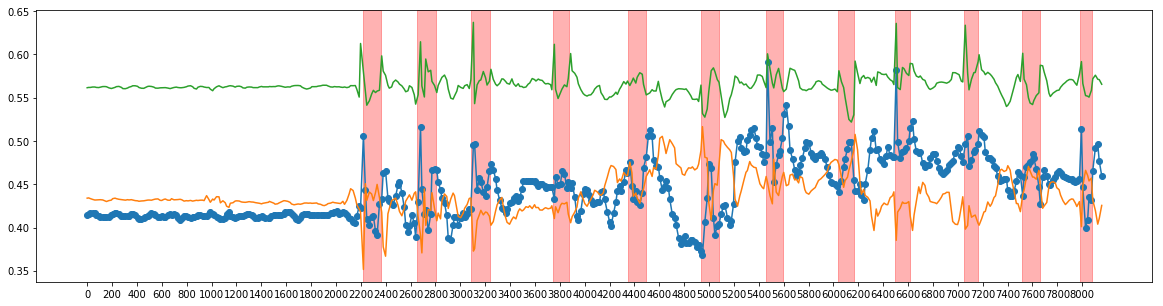

In [356]:
plt.figure(figsize=(20,5))

num_samples_to_view = 500
plot_end_time = acc_data[num_samples_to_view - 1][0]
acc_data_t_ms = acc_data[:num_samples_to_view, 0]
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 1], marker="o")
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 2])
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 3])

presses = [int(x[3]) - start_time for x in csvf if x[2] == "press" if int(x[3]) - start_time < plot_end_time]
releases = [int(x[3]) - start_time for x in csvf if x[2] == "release" if int(x[3]) - start_time < plot_end_time]

presses = presses[:min(len(presses), len(releases))]

for i in range(len(presses)):
    plt.axvspan(presses[i], releases[i], alpha=0.3, color="r")
    
plt.xticks(np.arange(0, plot_end_time, step=200))
plt.show()

In [357]:
# Interpolate
interp_times = np.linspace(0, end_time, num=num_samples)

acc_data_ts = acc_data[:,0]
# Check times all increasing
assert(np.all(np.diff(acc_data_ts) > 0))
acc_data_interp = [
    np.interp(interp_times, acc_data_ts, acc_data[:,1]),
    np.interp(interp_times, acc_data_ts, acc_data[:,2]),
    np.interp(interp_times, acc_data_ts, acc_data[:,3]),
]

gyro_data_ts = gyro_data[:,0]
assert(np.all(np.diff(gyro_data_ts) > 0))
gyro_data_interp = [
    np.interp(interp_times, gyro_data_ts, gyro_data[:,1]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,2]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,3]),
]

num_samples_to_view = 10000
acc_data_interp = np.array(acc_data_interp)
print(acc_data_interp.shape)
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[0, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[1, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[2, :num_samples_to_view])

all_data = np.concatenate((acc_data_interp, gyro_data_interp), axis=0).T
assert(all_data.shape == (num_samples, 6))
all_data = np.array(np.split(all_data, num_windows))
assert(all_data.shape == (num_windows, samples_per_window, 6))
print("Done.")

AssertionError: 

In [284]:
# Collect touch labels
# has_touch = 1 if there is a touch ONSET in that window
# TODO: might want to test this assumption

# (# presses, 3) array of (window #, touch_x, touch_y)
press_locs = np.array([[
    int(math.floor((int(x[3]) - start_time) / window_size_ms)), float(x[0]), float(x[1])
] for x in csvf if x[2] == "press"])

has_touch = -1 * np.ones((num_windows,))
touch_loc = -2 * np.ones((num_windows, 2))

has_touch[press_locs[:,0].astype(int)] = 1
touch_loc[press_locs[:,0].astype(int)] = press_locs[:,1:]
touch_loc = normalize(touch_loc)

assert(has_touch.shape == (num_windows,))
print("Number touch windows", np.sum(has_touch == 1))
print("Number no touch windows", np.sum(has_touch == -1))
assert(touch_loc.shape == (num_windows, 2))

Min:  [-2. -2.]
Range:  [413.14285278 772.28570557]
Number touch windows 1787
Number no touch windows 3829


/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


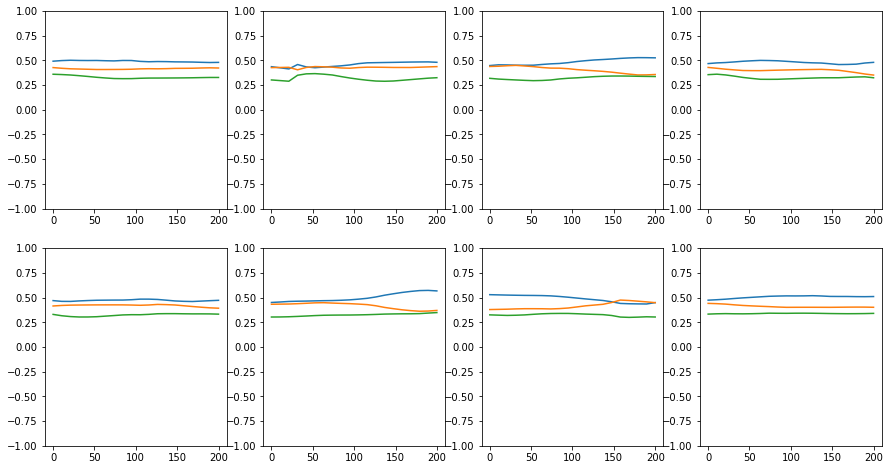

In [285]:
# Visualize touch / no touch windows
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == -1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


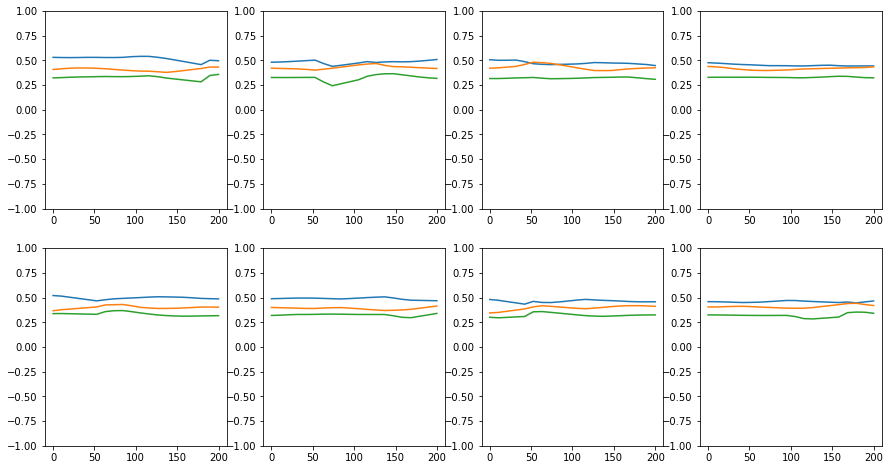

In [286]:
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == 1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

In [287]:
# Flatten into one feature vector before saving
all_data = all_data.reshape(-1, samples_per_window * 6)

print("all_data: ", all_data.shape)
print("has_touch: ", has_touch.shape)
print("touch_loc: ", touch_loc.shape)
np.save("processed/{}_x.npy".format(dataset), all_data)
np.save("processed/{}_has_touch_y.npy".format(dataset), has_touch)
np.save("processed/{}_touch_loc_y.npy".format(dataset), touch_loc)

all_data:  (5616, 120)
has_touch:  (5616,)
touch_loc:  (5616, 2)


# ~ machine learning ~

In [378]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from sklearn.model_selection import StratifiedKFold, train_test_split

from keras.optimizers import Adam
from keras import regularizers

In [368]:
X_balanced = np.load("processed/balanced_jessyiPhone_X.npy")
X_balanced = X_balanced.reshape(-1, 120)
has_touch_y_balanced = np.load("processed/balanced_jessyiPhone_has_touch_y.npy")

In [362]:
def visualize_classes(X, y, class_lbl, title=""):
    nrows = 8
    ncols = 8
    X = X.reshape((-1, samples_per_window, 6))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    axes = axes.reshape(-1)

    count = 0
    for i in range(50,len(y)):
        if y[i] == class_lbl:
            if count == nrows * ncols: break
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,0])
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,1])
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,2])
            axes[count].set_ylim(0, 1)
            axes[count].get_xaxis().set_visible(False)
            axes[count].get_yaxis().set_visible(False)
            count += 1
    fig.suptitle(title, fontsize=16)
    fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


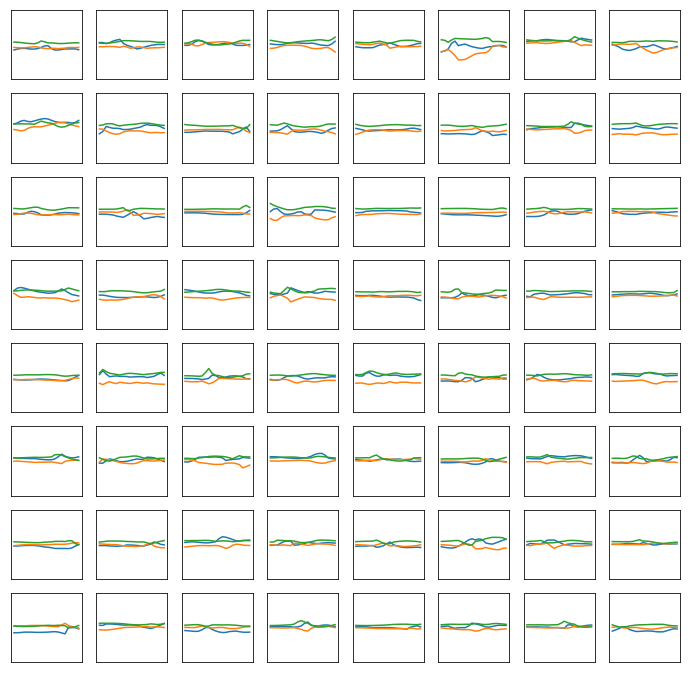

In [363]:
visualize_classes(X_balanced, has_touch_y_balanced, 1)

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


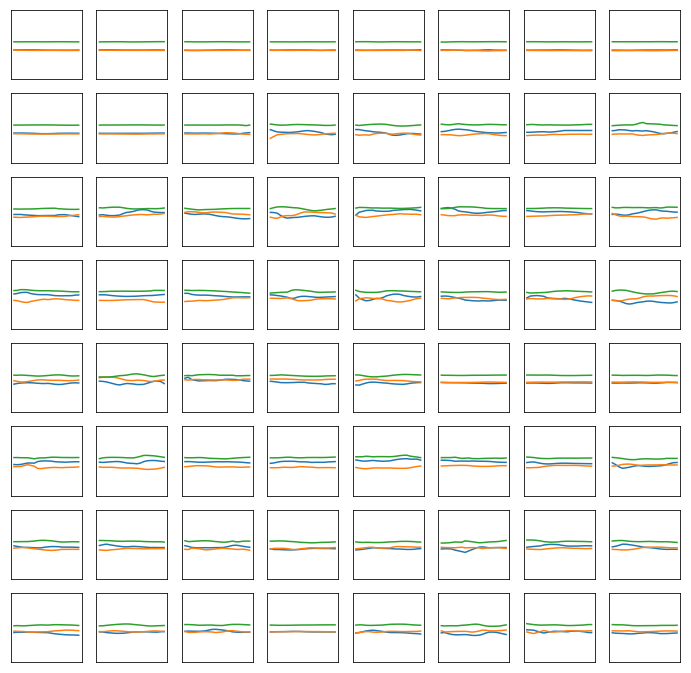

In [364]:
visualize_classes(X_balanced, has_touch_y_balanced, 0)

In [369]:
def build_model():
    model = Sequential()
    model.add(Dense(512, activation="relu", input_dim=(samples_per_window * 6)))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))#, kernel_regularizer=regularizers.l2(0.003)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=3e-4), metrics = ["accuracy"])
    return model

In [366]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)

In [311]:
seed = 0

accs = []
histories = []


for train_idx, test_idx in skf.split(X_balanced, has_touch_y_balanced):
    x_train, x_test = X_balanced[train_idx], X_balanced[test_idx]
    y_train, y_test = has_touch_y_balanced[train_idx], has_touch_y_balanced[test_idx]
    
    model = build_model()
    
    history = model.fit(x_train, y_train, epochs=125, batch_size=20, validation_data=(x_test, y_test))
    _, acc = model.evaluate(x_test, y_test)
    print("ACCURACY: ", acc)
    accs.append(acc)
    histories.append(history)

Train on 2858 samples, validate on 716 samples
Epoch 1/125
2858/2858 [==============================] - 0s - loss: 0.6868 - acc: 0.5469 - val_loss: 0.6735 - val_acc: 0.6411
Epoch 2/125
2858/2858 [==============================] - 0s - loss: 0.6668 - acc: 0.5847 - val_loss: 0.6713 - val_acc: 0.4986
Epoch 3/125
2858/2858 [==============================] - 0s - loss: 0.6514 - acc: 0.6116 - val_loss: 0.6666 - val_acc: 0.5014
Epoch 4/125
2858/2858 [==============================] - 0s - loss: 0.6458 - acc: 0.6113 - val_loss: 0.6228 - val_acc: 0.6648
Epoch 5/125
2858/2858 [==============================] - 0s - loss: 0.6398 - acc: 0.6218 - val_loss: 0.6382 - val_acc: 0.6355
Epoch 6/125
2858/2858 [==============================] - 0s - loss: 0.6235 - acc: 0.6477 - val_loss: 0.6421 - val_acc: 0.5852
Epoch 7/125
2858/2858 [==============================] - 0s - loss: 0.6205 - acc: 0.6491 - val_loss: 0.6082 - val_acc: 0.6732
Epoch 8/125
2858/2858 [==============================] - 0s - loss: 0.6

2858/2858 [==============================] - 0s - loss: 0.6669 - acc: 0.5906 - val_loss: 0.6502 - val_acc: 0.5992
Epoch 4/125
2858/2858 [==============================] - 0s - loss: 0.6438 - acc: 0.6302 - val_loss: 0.6259 - val_acc: 0.6592
Epoch 5/125
2858/2858 [==============================] - 0s - loss: 0.6389 - acc: 0.6190 - val_loss: 0.6690 - val_acc: 0.5810
Epoch 6/125
2858/2858 [==============================] - 0s - loss: 0.6268 - acc: 0.6533 - val_loss: 0.6123 - val_acc: 0.6550
Epoch 7/125
2858/2858 [==============================] - 0s - loss: 0.6266 - acc: 0.6449 - val_loss: 0.6165 - val_acc: 0.6620
Epoch 8/125
2858/2858 [==============================] - 0s - loss: 0.6166 - acc: 0.6515 - val_loss: 0.6315 - val_acc: 0.6243
Epoch 9/125
2858/2858 [==============================] - 0s - loss: 0.6192 - acc: 0.6466 - val_loss: 0.6189 - val_acc: 0.6508
Epoch 10/125
2858/2858 [==============================] - 0s - loss: 0.6094 - acc: 0.6610 - val_loss: 0.6514 - val_acc: 0.6173
Epo

KeyboardInterrupt: 

In [ ]:
print(accs)
np.mean(accs)

In [ ]:
plt.plot(histories[3].history["loss"])
plt.plot(histories[3].history["val_loss"])

Overfitting seems to happen around 100 epochs.

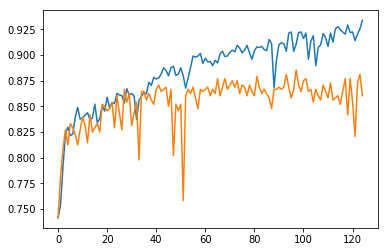

In [243]:
plt.plot(histories[1].history["acc"])
plt.plot(histories[1].history["val_acc"])

In [370]:
# Train on all data
x_train, x_test, y_train, y_test = train_test_split(X_balanced, has_touch_y_balanced, test_size=0.1)
model = build_model()
history = model.fit(x_train, y_train, epochs=250, batch_size=20, validation_data=(x_test, y_test))

Train on 2320 samples, validate on 258 samples
Epoch 1/250
2320/2320 [==============================] - 1s - loss: 0.6938 - acc: 0.5017 - val_loss: 0.6957 - val_acc: 0.4651
Epoch 2/250
2320/2320 [==============================] - 1s - loss: 0.6912 - acc: 0.5185 - val_loss: 0.6887 - val_acc: 0.5388
Epoch 3/250
2320/2320 [==============================] - 1s - loss: 0.6793 - acc: 0.5539 - val_loss: 0.7094 - val_acc: 0.4845
Epoch 4/250
2320/2320 [==============================] - 1s - loss: 0.6657 - acc: 0.5892 - val_loss: 0.6708 - val_acc: 0.5465
Epoch 5/250
2320/2320 [==============================] - 1s - loss: 0.6679 - acc: 0.5642 - val_loss: 0.6771 - val_acc: 0.5116
Epoch 6/250
2320/2320 [==============================] - 1s - loss: 0.6781 - acc: 0.5353 - val_loss: 0.6943 - val_acc: 0.4651
Epoch 7/250
2320/2320 [==============================] - 1s - loss: 0.6874 - acc: 0.5211 - val_loss: 0.6966 - val_acc: 0.4651
Epoch 8/250
2320/2320 [==============================] - 1s - loss: 0.6

2320/2320 [==============================] - 3s - loss: 0.5171 - acc: 0.7384 - val_loss: 0.5100 - val_acc: 0.7364
Epoch 66/250
2320/2320 [==============================] - 3s - loss: 0.5009 - acc: 0.7448 - val_loss: 0.4972 - val_acc: 0.7519
Epoch 67/250
2320/2320 [==============================] - 3s - loss: 0.4998 - acc: 0.7453 - val_loss: 0.5197 - val_acc: 0.7442
Epoch 68/250
2320/2320 [==============================] - 3s - loss: 0.4917 - acc: 0.7500 - val_loss: 0.4466 - val_acc: 0.7946
Epoch 69/250
2320/2320 [==============================] - 3s - loss: 0.5071 - acc: 0.7448 - val_loss: 0.4756 - val_acc: 0.7713
Epoch 70/250
2320/2320 [==============================] - 3s - loss: 0.4961 - acc: 0.7543 - val_loss: 0.4541 - val_acc: 0.7868
Epoch 71/250
2320/2320 [==============================] - 3s - loss: 0.4902 - acc: 0.7509 - val_loss: 0.4572 - val_acc: 0.7907
Epoch 72/250
2320/2320 [==============================] - 3s - loss: 0.4830 - acc: 0.7474 - val_loss: 0.4680 - val_acc: 0.77

2320/2320 [==============================] - 3s - loss: 0.4510 - acc: 0.7711 - val_loss: 0.4974 - val_acc: 0.7713
Epoch 130/250
2320/2320 [==============================] - 3s - loss: 0.4503 - acc: 0.7651 - val_loss: 0.4721 - val_acc: 0.7752
Epoch 131/250
2320/2320 [==============================] - 4s - loss: 0.4287 - acc: 0.7879 - val_loss: 0.5063 - val_acc: 0.7752
Epoch 132/250
2320/2320 [==============================] - 4s - loss: 0.4281 - acc: 0.7888 - val_loss: 0.4610 - val_acc: 0.7829
Epoch 133/250
2320/2320 [==============================] - 3s - loss: 0.4369 - acc: 0.7853 - val_loss: 0.4227 - val_acc: 0.7946
Epoch 134/250
2320/2320 [==============================] - 3s - loss: 0.4313 - acc: 0.7853 - val_loss: 0.5141 - val_acc: 0.7326
Epoch 135/250
2320/2320 [==============================] - 3s - loss: 0.4519 - acc: 0.7759 - val_loss: 0.4414 - val_acc: 0.7791
Epoch 136/250
2320/2320 [==============================] - 4s - loss: 0.4442 - acc: 0.7871 - val_loss: 0.4498 - val_ac

2320/2320 [==============================] - 4s - loss: 0.4093 - acc: 0.7966 - val_loss: 0.4270 - val_acc: 0.7829
Epoch 194/250
2320/2320 [==============================] - 4s - loss: 0.4080 - acc: 0.8009 - val_loss: 0.4445 - val_acc: 0.8062
Epoch 195/250
2320/2320 [==============================] - 4s - loss: 0.4141 - acc: 0.7983 - val_loss: 0.4205 - val_acc: 0.8140
Epoch 196/250
2320/2320 [==============================] - 4s - loss: 0.3885 - acc: 0.8073 - val_loss: 0.5193 - val_acc: 0.7636
Epoch 197/250
2320/2320 [==============================] - 3s - loss: 0.4036 - acc: 0.8078 - val_loss: 0.5253 - val_acc: 0.7558
Epoch 198/250
2320/2320 [==============================] - 3s - loss: 0.4110 - acc: 0.7957 - val_loss: 0.4241 - val_acc: 0.8062
Epoch 199/250
2320/2320 [==============================] - 3s - loss: 0.3952 - acc: 0.8039 - val_loss: 0.4669 - val_acc: 0.7868
Epoch 200/250
2320/2320 [==============================] - 4s - loss: 0.3950 - acc: 0.8017 - val_loss: 0.4691 - val_ac

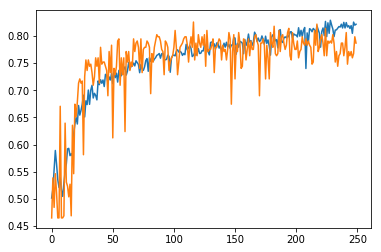

In [371]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [372]:
print(history.history["val_acc"][-1])

0.7868217045022535


In [381]:
def build_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(samples_per_window, 6)))
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
   # model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=3e-4), metrics = ["accuracy"])
    return model

In [382]:
# Train on all data
X_balanced = X_balanced.reshape(-1, 20, 6)
x_train, x_test, y_train, y_test = train_test_split(X_balanced, has_touch_y_balanced, test_size=0.1)
cnn_model = build_cnn_model()
history = cnn_model.fit(x_train, y_train, epochs=250, batch_size=20, validation_data=(x_test, y_test))

Train on 2320 samples, validate on 258 samples
Epoch 1/250
2320/2320 [==============================] - 0s - loss: 0.6928 - acc: 0.5056 - val_loss: 0.6834 - val_acc: 0.5194
Epoch 2/250
2320/2320 [==============================] - 0s - loss: 0.6689 - acc: 0.5953 - val_loss: 0.6621 - val_acc: 0.6279
Epoch 3/250
2320/2320 [==============================] - 0s - loss: 0.6338 - acc: 0.6379 - val_loss: 0.6476 - val_acc: 0.6124
Epoch 4/250
2320/2320 [==============================] - 0s - loss: 0.6177 - acc: 0.6392 - val_loss: 0.6325 - val_acc: 0.6240
Epoch 5/250
2320/2320 [==============================] - 0s - loss: 0.6076 - acc: 0.6634 - val_loss: 0.6237 - val_acc: 0.6512
Epoch 6/250
2320/2320 [==============================] - 0s - loss: 0.6041 - acc: 0.6517 - val_loss: 0.5998 - val_acc: 0.6860
Epoch 7/250
2320/2320 [==============================] - 0s - loss: 0.5869 - acc: 0.6832 - val_loss: 0.6205 - val_acc: 0.6357
Epoch 8/250
2320/2320 [==============================] - 0s - loss: 0.5

2320/2320 [==============================] - 0s - loss: 0.3812 - acc: 0.8185 - val_loss: 0.4413 - val_acc: 0.7984
Epoch 66/250
2320/2320 [==============================] - 0s - loss: 0.3836 - acc: 0.8198 - val_loss: 0.4761 - val_acc: 0.7868
Epoch 67/250
2320/2320 [==============================] - 0s - loss: 0.3917 - acc: 0.8142 - val_loss: 0.4451 - val_acc: 0.7868
Epoch 68/250
2320/2320 [==============================] - 0s - loss: 0.3768 - acc: 0.8224 - val_loss: 0.4407 - val_acc: 0.8062
Epoch 69/250
2320/2320 [==============================] - 0s - loss: 0.3762 - acc: 0.8220 - val_loss: 0.4650 - val_acc: 0.7907
Epoch 70/250
2320/2320 [==============================] - 0s - loss: 0.3716 - acc: 0.8142 - val_loss: 0.4345 - val_acc: 0.8178
Epoch 71/250
2320/2320 [==============================] - 0s - loss: 0.3684 - acc: 0.8319 - val_loss: 0.4528 - val_acc: 0.8140
Epoch 72/250
2320/2320 [==============================] - 0s - loss: 0.3645 - acc: 0.8315 - val_loss: 0.4670 - val_acc: 0.77

2320/2320 [==============================] - 0s - loss: 0.2577 - acc: 0.8966 - val_loss: 0.3920 - val_acc: 0.8256
Epoch 130/250
2320/2320 [==============================] - 0s - loss: 0.2656 - acc: 0.8892 - val_loss: 0.3754 - val_acc: 0.8333
Epoch 131/250
2320/2320 [==============================] - 0s - loss: 0.2611 - acc: 0.8845 - val_loss: 0.3412 - val_acc: 0.8488
Epoch 132/250
2320/2320 [==============================] - 0s - loss: 0.2646 - acc: 0.8879 - val_loss: 0.3368 - val_acc: 0.8488
Epoch 133/250
2320/2320 [==============================] - 0s - loss: 0.2487 - acc: 0.9009 - val_loss: 0.3597 - val_acc: 0.8527
Epoch 134/250
2320/2320 [==============================] - 0s - loss: 0.2491 - acc: 0.8935 - val_loss: 0.3604 - val_acc: 0.8488
Epoch 135/250
2320/2320 [==============================] - 0s - loss: 0.2503 - acc: 0.8953 - val_loss: 0.3523 - val_acc: 0.8411
Epoch 136/250
2320/2320 [==============================] - 0s - loss: 0.2441 - acc: 0.8974 - val_loss: 0.3504 - val_ac

2320/2320 [==============================] - 0s - loss: 0.1927 - acc: 0.9224 - val_loss: 0.3240 - val_acc: 0.8837
Epoch 194/250
2320/2320 [==============================] - 0s - loss: 0.1981 - acc: 0.9147 - val_loss: 0.3344 - val_acc: 0.8721
Epoch 195/250
2320/2320 [==============================] - 0s - loss: 0.2003 - acc: 0.9185 - val_loss: 0.3110 - val_acc: 0.8682
Epoch 196/250
2320/2320 [==============================] - 0s - loss: 0.1990 - acc: 0.9211 - val_loss: 0.3423 - val_acc: 0.8643
Epoch 197/250
2320/2320 [==============================] - 0s - loss: 0.2045 - acc: 0.9155 - val_loss: 0.3292 - val_acc: 0.8566
Epoch 198/250
2320/2320 [==============================] - 0s - loss: 0.1917 - acc: 0.9168 - val_loss: 0.3562 - val_acc: 0.8566
Epoch 199/250
2320/2320 [==============================] - 0s - loss: 0.1930 - acc: 0.9164 - val_loss: 0.2994 - val_acc: 0.8760
Epoch 200/250
2320/2320 [==============================] - 0s - loss: 0.1878 - acc: 0.9241 - val_loss: 0.3164 - val_ac

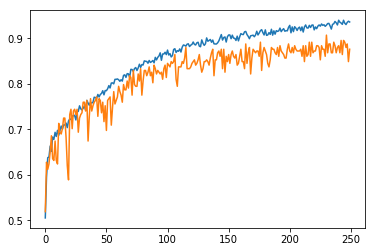

In [383]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [384]:
print(history.history["val_acc"][-1])

0.8759689880895984


In [386]:
cnn_model.save("has_touch_model_cnn.h5")

In [257]:
from keras.models import load_model
loadedmodel = load_model("has_touch_model.h5")